In [17]:
import pandas as pd
import random
import math
import numpy as np
import heapq
import matplotlib.pyplot as plt
"""
author:Jackey Zhou
emails:1900432020@email.szu.edu.cn
"""

'\nauthor:Jackey Zhou\nemails:1900432020@email.szu.edu.cn\n'

In [18]:
class lfm(object):
    def __init__(self, df, n_fold=10, k=100, iter=10, lr=.005, reg=.02):
        """
        base LFM model
        :param df: all moivelens dataframe,format:user item rating timestamp
        :param n_fold:n_fold cross validation
        :param k: latent factor number
        :param iter: iteration cycle number
        :param lr: learning rate
        :param reg: regulation parameter
        :return:None(can be modified to return what you what)
        """
#        set random seed to replay shuffle index
        random.seed(5)
        all_len=len(df.index)
        all_index=[i for i in range(all_len)]
        random.shuffle(all_index)
        test_len=math.floor(all_len/n_fold)
        rmse=[]
        correct_rate={}
#         default setting is ten fold cross validation
        for valid in range(n_fold):
            print('fold:', valid, ' n_fold:', n_fold)
#             split dataset to trainset and testset
            test_index=all_index[valid*test_len:(valid+1)*test_len]
            train_index=all_index[:valid*test_len]
            train_index.extend(all_index[(valid+1)*test_len:])
            train_df=df.iloc[train_index]
            test_df=df.iloc[test_index]
#             apply LFM algorithm to learn p,q matrix
            [p,q]=self.lfm_learn(df,train_df,k,iter,lr,reg)
#             apply trained matrix to test rmse in one fold
            rmse.append(self.test_rmse(test_df,p,q))
#             test top10 to top50 recommendation precision
            top_K_range=range(10,50)
            for i in top_K_range:
#             ignore topK recommending movies,just take its correctrate
                [_,valid_correct_rate]=self.test_topk(df,train_df,test_df,p,q,i)
                if i not in correct_rate:
                    correct_rate[i]=[]
                correct_rate[i].append(valid_correct_rate)
#         mean rmse in all fold
        rmse_all=np.mean(rmse)
        avg_correct_rate=dict()
#         mean topK precision in all fold
        for key in correct_rate:
            avg_correct_rate[key]=np.mean(correct_rate[key])
        print('overall rmse:',rmse_all)
        correct_rate_lists = sorted(avg_correct_rate.items())
        x, y = zip(*correct_rate_lists)
        plt.plot(x, y)
        plt.xlabel('K largest rating movies')
        plt.ylabel('percentage of testset movie number in topK recommendation movies')
        plt.title('topK recommendation precision')
        plt.show()
        
            
    
    @staticmethod
    def lfm_init(df, k):
        """
        lfm init algorithm,override it to change init strategy
        :param df: all moivelens dataframe,format:user item rating timestamp
        :param k: latent factor number
        :return: initial p,q in a list
        """
        p = dict()
        q = dict()
        for row in df.itertuples(index=False):
            list_row=list(row)
            u = list_row[0]
            i = list_row[1]
            rating = list_row[2]
            if u not in p:
                p[u] = [random.random()/math.sqrt(k) for x in range(0, k)]
            if i not in q:
                q[i] = [random.random() / math.sqrt(k) for x in range(0, k)]
        return [p, q]


    def lfm_learn(self,df,train_df, k,iter,lr,reg):
        """
        lfm learn logical function to call lfm_init and algorithm
        :param df: all moivelens dataframe,format:user item rating timestamp
        :param train_df: train moivelens dataframe,format:user item rating timestamp
        :param k: latent factor number
        :param iter: iteration cycle number
        :param lr: learning rate
        :param reg: regulation parameter
        :return: trained p,q in a list
        """
        [p,q]=self.lfm_init(df, k)
        [p,q]=self.algorithm(train_df,p,q,k,iter,lr,reg)
        return [p,q]

    def algorithm(self,df,p,q,k,iter,lr,reg):
        """
        lfm train algorithm,override it to change train strategy
        :param df: train moivelens dataframe,format:user item rating timestamp
        :param k: latent factor number
        :param iter: iteration cycle number
        :param lr: learning rate
        :param reg: regulation parameter
        :return:trained p,q in a list
        """
        for step in range(0,iter):
            print('   step:',step, ' steps_num:', iter)
            for row in df.itertuples(index=False):
                list_row=list(row)
                u = list_row[0]
                i = list_row[1]
                rating = list_row[2]
                lfm_predict=self.predict(u,i,p,q)
                error=rating - lfm_predict
                for f in range(0,k):
                    p[u][f] += lr*(q[i][f]*error - reg*p[u][f])
                    q[i][f] += lr*(p[u][f]*error - reg*q[i][f])
#             reduct learning rate to limit search space
            lr*=0.9
        return [p,q]
    
    @staticmethod
    def predict(u,i,p,q):
        """
        lfm predict function,given preference according to user u and item i by multiply p_u and q_i
        :param u: userId
        :param i: itemId
        :param p: trained user matrix
        :param q: trained item matrix
        :return:user u's perference to item i
        """
        return sum(p[u][f]*q[i][f] for f in range(0,len(p[u])))
    

    def test_rmse(self,test_df,p,q):
        """
        estimate rating in testset to test rmse
        :param test_df: test moivelens dataframe,format:user item rating timestamp
        :param p: trained user matrix
        :param q: trained item matrix
        :return:rmse
        """
        errors=[]
        for row in df.itertuples(index=False):
            list_row=list(row)
            u = list_row[0]
            i = list_row[1]
            rating = list_row[2]
            lfm_predict=self.predict(u,i,p,q)
            error=rating - lfm_predict
            errors.append(error**2)
        mse=np.mean(errors)
        rmse=np.sqrt(mse)
        print('rmse:', rmse)
        return rmse
    

    def test_topk(self,df,train_df,test_df,p,q,top_k):
        """
        :param train_df: train moivelens dataframe,format:user item rating timestamp
        :param test_df: test moivelens dataframe,format:user item rating timestamp
        :param p: trained user matrix
        :param q: trained item matrix
        :param top_k: recommend top_k number of movies
        :return:top_k recommendation movies and top_K recommendation precision
        """
        train_user=train_df['userId'].unique()
        test_user=test_df['userId'].unique()
#         filter common user in both trainset and testset
        common_user=np.intersect1d(train_user,test_user)
        recommend_movies=dict()
        movies_num=0
        correct_num=0
        for u in common_user:
            heap=dict()
#             count user preference in all movies
            for i in df.loc[df['userId'] == u]['movieId']:
                heap[i]=self.predict(u,i,p,q)
#             get top_K largest movieId
            top_k_movies = heapq.nlargest(top_k, heap)
            user_test_movies=test_df.loc[test_df['userId'] == u]['movieId'].to_numpy()
#             get common movies in both top_K recommendation and testset of specified user
            common_movies=np.intersect1d(top_k_movies,user_test_movies)
            correct_num+=len(common_movies)
#             if user's testset movie number less than top_K number, add user's testset movie number as it's max common number
            movies_num+=top_k if len(user_test_movies)>top_k else len(user_test_movies)
            recommend_movies[u]=top_k_movies
#         count correct rate
        correct_rate=correct_num/movies_num
        print('top_k:',top_k,' correct_rate:',correct_rate)
#       return correct rate and topK recommend movies
        return [recommend_movies,correct_rate]
        
        
        

In [19]:
df = pd.read_csv('ml-latest-small/ratings.csv')

fold: 0  n_fold: 10
   step: 0  steps_num: 10
   step: 1  steps_num: 10
   step: 2  steps_num: 10
   step: 3  steps_num: 10
   step: 4  steps_num: 10
   step: 5  steps_num: 10
   step: 6  steps_num: 10
   step: 7  steps_num: 10
   step: 8  steps_num: 10
   step: 9  steps_num: 10
rmse: 0.9264988130705324
top_k: 10  correct_rate: 0.1442115768463074
top_k: 11  correct_rate: 0.1509433962264151
top_k: 12  correct_rate: 0.15596947935368044
top_k: 13  correct_rate: 0.16473367697594501
top_k: 14  correct_rate: 0.1724494010739364
top_k: 15  correct_rate: 0.17897670714712324
top_k: 16  correct_rate: 0.18636888717751252
top_k: 17  correct_rate: 0.1916402313864527
top_k: 18  correct_rate: 0.1963379260333575
top_k: 19  correct_rate: 0.20176522506619593
top_k: 20  correct_rate: 0.20654044750430292
top_k: 21  correct_rate: 0.2111017661900757
top_k: 22  correct_rate: 0.2160737812911726
top_k: 23  correct_rate: 0.2198547215496368
top_k: 24  correct_rate: 0.22473867595818817
top_k: 25  correct_rate: 0.2

top_k: 47  correct_rate: 0.31726957383548066
top_k: 48  correct_rate: 0.32212781677133356
top_k: 49  correct_rate: 0.3250091810503122
fold: 4  n_fold: 10
   step: 0  steps_num: 10
   step: 1  steps_num: 10
   step: 2  steps_num: 10
   step: 3  steps_num: 10
   step: 4  steps_num: 10
   step: 5  steps_num: 10
   step: 6  steps_num: 10
   step: 7  steps_num: 10
   step: 8  steps_num: 10
   step: 9  steps_num: 10
rmse: 0.9270182526124685
top_k: 10  correct_rate: 0.1520078837152008
top_k: 11  correct_rate: 0.15798045602605862
top_k: 12  correct_rate: 0.1644925934114526
top_k: 13  correct_rate: 0.16849894291754758
top_k: 14  correct_rate: 0.17062766605728213
top_k: 15  correct_rate: 0.17515673981191224
top_k: 16  correct_rate: 0.18064516129032257
top_k: 17  correct_rate: 0.1869244935543278
top_k: 18  correct_rate: 0.1913558106169297
top_k: 19  correct_rate: 0.19601328903654486
top_k: 20  correct_rate: 0.2033811475409836
top_k: 21  correct_rate: 0.20747788349190452
top_k: 22  correct_rate: 0

top_k: 44  correct_rate: 0.3053521837919717
top_k: 45  correct_rate: 0.30763444904099285
top_k: 46  correct_rate: 0.31079566679118414
top_k: 47  correct_rate: 0.3140771895101435
top_k: 48  correct_rate: 0.3163265306122449
top_k: 49  correct_rate: 0.31935956978733804
fold: 8  n_fold: 10
   step: 0  steps_num: 10
   step: 1  steps_num: 10
   step: 2  steps_num: 10
   step: 3  steps_num: 10
   step: 4  steps_num: 10
   step: 5  steps_num: 10
   step: 6  steps_num: 10
   step: 7  steps_num: 10
   step: 8  steps_num: 10
   step: 9  steps_num: 10
rmse: 0.9271092857699738
top_k: 10  correct_rate: 0.15557729941291584
top_k: 11  correct_rate: 0.1604909680407596
top_k: 12  correct_rate: 0.16967827236668137
top_k: 13  correct_rate: 0.174573055028463
top_k: 14  correct_rate: 0.18060064935064934
top_k: 15  correct_rate: 0.18596903782088967
top_k: 16  correct_rate: 0.19165085388994307
top_k: 17  correct_rate: 0.19594843462246778
top_k: 18  correct_rate: 0.20039398280802292
top_k: 19  correct_rate: 0

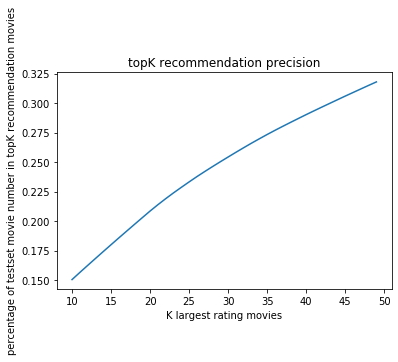

In [20]:
org_lfm=lfm(df)

In [21]:
class bias_lfm(object):
    def __init__(self, df, n_fold=10, k=100, iter=10, lr=.005, reg=.02):
        """
        :param df: all moivelens dataframe,format:user item rating timestamp
        :param n_fold:n_fold cross validation
        :param k: latent factor number
        :param iter: iteration cycle number
        :param lr: learning rate
        :param reg: regulation parameter
        :return:None(can be modified to return what you what)
        """
        random.seed(5)
        all_len=len(df.index)
        all_index=[i for i in range(all_len)]
        random.shuffle(all_index)
        test_len=math.floor(all_len/n_fold)
        rmse=[]
        correct_rate={}
        for valid in range(n_fold):
            print('fold:', valid, ' n_fold:', n_fold)
            test_index=all_index[valid*test_len:(valid+1)*test_len]
            train_index=all_index[:valid*test_len]
            train_index.extend(all_index[(valid+1)*test_len:])
            train_df=df.iloc[train_index]
            test_df=df.iloc[test_index]
            [bu,bi,p,q,mu]=self.lfm_learn(df,train_df,k,iter,lr,reg)
            rmse.append(self.test_rmse(test_df,bu,bi,p,q,mu))
            top_K_range=range(10,50)
            for i in top_K_range:
                [_,valid_correct_rate]=self.test_topk(df,train_df,test_df,bu,bi,p,q,i,mu)
                if i not in correct_rate:
                    correct_rate[i]=[]
                correct_rate[i].append(valid_correct_rate)
        rmse_all=np.mean(rmse)
        avg_correct_rate=dict()
        for key in correct_rate:
            avg_correct_rate[key]=np.mean(correct_rate[key])
        print('overall rmse:',rmse_all)
        correct_rate_lists = sorted(avg_correct_rate.items())
        x, y = zip(*correct_rate_lists)
        plt.plot(x, y)
        plt.xlabel('K largest rating movies')
        plt.ylabel('percentage of testset movie number in topK recommendation movies')
        plt.title('topK recommendation precision')
        plt.show()
    
    @staticmethod
    def lfm_init(df, k):
        """
        lfm init algorithm,override it to change init strategy
        :param df: all moivelens dataframe,format:user item rating timestamp
        :param k: latent factor number
        :return: initial bu,bi,p,q,mu in a list
        """
        p = dict()
        q = dict()
        bu=dict()
        bi=dict()
#         count mean of all ratings
        mu=df["rating"].mean()
        for row in df.itertuples(index=False):
            list_row=list(row)
            u = list_row[0]
            i = list_row[1]
            rating = list_row[2]
#             init bias of users and items with zero padding
            bu[u]=0
            bi[i]=0
            if u not in p:
                p[u] = [random.random()/math.sqrt(k) for x in range(0, k)]
            if i not in q:
                q[i] = [random.random() / math.sqrt(k) for x in range(0, k)]
        return [bu, bi, p, q,mu]
    
    def lfm_learn(self,df,train_df, k,iter,lr,reg):
        """
        lfm learn logical function to call lfm_init and algorithm
        :param df: all moivelens dataframe,format:user item rating timestamp
        :param train_df: train moivelens dataframe,format:user item rating timestamp
        :param k: latent factor number
        :param iter: iteration cycle number
        :param lr: learning rate
        :param reg: regulation parameter
        :return: trained bu,bi,p,q,mu in a list
        """
        [bu,bi,p,q,mu]=self.lfm_init(df, k)
        [bu,bi,p,q,mu]=self.algorithm(train_df,bu,bi,p,q,k,iter,lr,reg,mu)
        return [bu,bi,p,q,mu]
    
    def algorithm(self,df,bu,bi,p,q,k,iter,lr,reg,mu):
        """
        lfm train algorithm,override it to change train strategy
        :param df: train moivelens dataframe,format:user item rating timestamp
        :param bu: user bias 
        :param bi: item bias 
        :param k: latent factor number
        :param iter: iteration cycle number
        :param lr: learning rate
        :param reg: regulation parameter
        :param mu: global rating mean
        :return:trained p,q in a list
        """
        for step in range(0,iter):
            print('   step:',step, ' steps_num:', iter)
            for row in df.itertuples(index=False):
                list_row=list(row)
                u = list_row[0]
                i = list_row[1]
                rating = list_row[2]
                lfm_predict=self.predict(u,i,bu,bi,p,q,mu)
                error=rating - lfm_predict
#                 update user bias and item bias
                bu[u]+=lr*(error-reg*bu[u])
                bi[i]+=lr*(error-reg*bi[i])
                for f in range(0,k):
                    p[u][f] += lr*(q[i][f]*error - reg*p[u][f])
                    q[i][f] += lr*(p[u][f]*error - reg*q[i][f])
            lr*=0.9
        return [bu,bi,p,q,mu]
    
    @staticmethod
    def predict(u,i,bu,bi,p,q,mu):
        """
        lfm predict function,given preference according to user u and item i by multiply p_u and q_i plus bias
        :param u: userId
        :param i: itemId
        :param bu: user bias  
        :param bi: item bias 
        :param p: trained user matrix
        :param q: trained item matrix
        :param mu: mean of all ratings
        :return:user u's perference to item i
        """
        bias=mu+bu[u]+bi[i]
        return sum(p[u][f]*q[i][f] for f in range(0,len(p[u])))+bias
    
    def test_rmse(self,test_df,bu,bi,p,q,mu):
        """
        estimate rating in testset to test rmse
        :param test_df: test moivelens dataframe,format:user item rating timestamp
        :param bu: user bias  
        :param bi: item bias
        :param p: trained user matrix
        :param q: trained item matrix
        :param mu: mean of all ratings
        :return:rmse
        """
        errors=[]
        for row in df.itertuples(index=False):
            list_row=list(row)
            u = list_row[0]
            i = list_row[1]
            rating = list_row[2]
            lfm_predict=self.predict(u,i,bu,bi,p,q,mu)
            error=rating - lfm_predict
            errors.append(error**2)
        mse=np.mean(errors)
        rmse=np.sqrt(mse)
        print('rmse:', rmse)
        return rmse
    

    def test_topk(self,df,train_df,test_df,bu,bi,p,q,top_k,mu):
        """
        :param train_df: train moivelens dataframe,format:user item rating timestamp
        :param test_df: test moivelens dataframe,format:user item rating timestamp
        :param bu: user bias  
        :param bi: item bias
        :param p: trained user matrix
        :param q: trained item matrix
        :param top_k: recommend top_k number of movies
        :param mu: mean of all ratings
        :return:top_k recommendation movies and top_K recommendation precision
        """
        train_user=train_df['userId'].unique()
        test_user=test_df['userId'].unique()
        common_user=np.intersect1d(train_user,test_user)
        recommend_movies=dict()
        movies_num=0
        correct_num=0
        for u in common_user:
            heap=dict()
            for i in df.loc[df['userId'] == u]['movieId']:
                heap[i]=self.predict(u,i,bu,bi,p,q,mu)
            top_k_movies = heapq.nlargest(top_k, heap)
            user_test_movies=test_df.loc[test_df['userId'] == u]['movieId'].to_numpy()
            common_movies=np.intersect1d(top_k_movies,user_test_movies)
            correct_num+=len(common_movies)
            movies_num+=top_k if len(user_test_movies)>top_k else len(user_test_movies)
            recommend_movies[u]=top_k_movies
        correct_rate=correct_num/movies_num
        print('top_k:',top_k,' correct_rate:',correct_rate)
        return [recommend_movies,correct_rate]

fold: 0  n_fold: 10
   step: 0  steps_num: 10
   step: 1  steps_num: 10
   step: 2  steps_num: 10
   step: 3  steps_num: 10
   step: 4  steps_num: 10
   step: 5  steps_num: 10
   step: 6  steps_num: 10
   step: 7  steps_num: 10
   step: 8  steps_num: 10
   step: 9  steps_num: 10
rmse: 0.8537120605673196
top_k: 10  correct_rate: 0.1442115768463074
top_k: 11  correct_rate: 0.1509433962264151
top_k: 12  correct_rate: 0.15596947935368044
top_k: 13  correct_rate: 0.16473367697594501
top_k: 14  correct_rate: 0.1724494010739364
top_k: 15  correct_rate: 0.17897670714712324
top_k: 16  correct_rate: 0.18636888717751252
top_k: 17  correct_rate: 0.1916402313864527
top_k: 18  correct_rate: 0.1963379260333575
top_k: 19  correct_rate: 0.20176522506619593
top_k: 20  correct_rate: 0.20654044750430292
top_k: 21  correct_rate: 0.2111017661900757
top_k: 22  correct_rate: 0.2160737812911726
top_k: 23  correct_rate: 0.2198547215496368
top_k: 24  correct_rate: 0.22473867595818817
top_k: 25  correct_rate: 0.2

top_k: 47  correct_rate: 0.31726957383548066
top_k: 48  correct_rate: 0.32212781677133356
top_k: 49  correct_rate: 0.3250091810503122
fold: 4  n_fold: 10
   step: 0  steps_num: 10
   step: 1  steps_num: 10
   step: 2  steps_num: 10
   step: 3  steps_num: 10
   step: 4  steps_num: 10
   step: 5  steps_num: 10
   step: 6  steps_num: 10
   step: 7  steps_num: 10
   step: 8  steps_num: 10
   step: 9  steps_num: 10
rmse: 0.8538665758156895
top_k: 10  correct_rate: 0.1520078837152008
top_k: 11  correct_rate: 0.15798045602605862
top_k: 12  correct_rate: 0.1644925934114526
top_k: 13  correct_rate: 0.16849894291754758
top_k: 14  correct_rate: 0.17062766605728213
top_k: 15  correct_rate: 0.17515673981191224
top_k: 16  correct_rate: 0.18064516129032257
top_k: 17  correct_rate: 0.1869244935543278
top_k: 18  correct_rate: 0.1913558106169297
top_k: 19  correct_rate: 0.19601328903654486
top_k: 20  correct_rate: 0.2033811475409836
top_k: 21  correct_rate: 0.20747788349190452
top_k: 22  correct_rate: 0

top_k: 44  correct_rate: 0.3053521837919717
top_k: 45  correct_rate: 0.30763444904099285
top_k: 46  correct_rate: 0.31079566679118414
top_k: 47  correct_rate: 0.3140771895101435
top_k: 48  correct_rate: 0.3163265306122449
top_k: 49  correct_rate: 0.31935956978733804
fold: 8  n_fold: 10
   step: 0  steps_num: 10
   step: 1  steps_num: 10
   step: 2  steps_num: 10
   step: 3  steps_num: 10
   step: 4  steps_num: 10
   step: 5  steps_num: 10
   step: 6  steps_num: 10
   step: 7  steps_num: 10
   step: 8  steps_num: 10
   step: 9  steps_num: 10
rmse: 0.853706098264993
top_k: 10  correct_rate: 0.15557729941291584
top_k: 11  correct_rate: 0.1604909680407596
top_k: 12  correct_rate: 0.16967827236668137
top_k: 13  correct_rate: 0.174573055028463
top_k: 14  correct_rate: 0.18060064935064934
top_k: 15  correct_rate: 0.18596903782088967
top_k: 16  correct_rate: 0.19165085388994307
top_k: 17  correct_rate: 0.19594843462246778
top_k: 18  correct_rate: 0.20039398280802292
top_k: 19  correct_rate: 0.

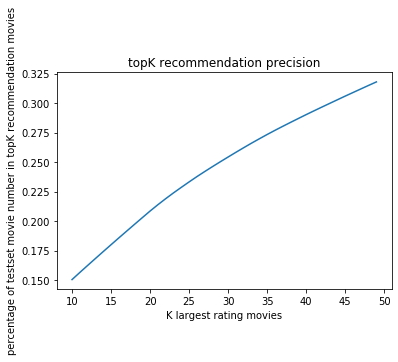

In [22]:
b_lfm=bias_lfm(df)